In [10]:
import common.star_api.design_manager as dm
import common.visualization as viz
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

work_dir = Path(r"/u/cd2sja/PROJECTS/hackathon/pod/star")
name = "PandoraComfortSweep"
version = "19.04.007"
distrib =r"/u/cd2sja/PROJECTS/hackathon/install/STAR-CCM+19.04.007-2-ga404231/star/bin/starccm+"
port = 47827

In [8]:
def train(study):
    pass
def predict(field):
    pass
s1_study = None

In [12]:
# Prepare boundary_conditions data from Design Set
dmprj_path = work_dir.joinpath(f"{name}.dmprj")
dmprj = dm.DesignManagerProject.get_live_proj(dmprj_path=dmprj_path, port=port, distrib=distrib, version=version)
s1_study = dmprj.get_study("Design Study")
allDesignSet = s1_study.get_all_designs()
d = allDesignSet.data_frame()
d.style
nDesigns = d.shape[0]
boundary_conditions = d.copy()
boundary_conditions.rename({'Design#':'Design', 'HVAC_FlowRate (kg/s)':'HVAC_FlowRate', 'Heater_Seats (W/m^2)':'Heater_Seats', 'Heater_Radiant (W)':'Heater_Radiant','HVAC_Temperature (C)':'HVAC_Temperature'}, axis=1, inplace=True)
boundary_conditions = boundary_conditions[['Design', 'Heater_Radiant','Heater_Seats','HVAC_FlowRate','HVAC_Temperature']]
boundary_conditions = boundary_conditions.loc[boundary_conditions.index.repeat(30)].reset_index(drop=True)
times=[20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600]*nDesigns
boundary_conditions.insert( loc=1, column='Time', value=times)
nRows = boundary_conditions.shape[0]
#designNumbers=[i for i in range(1,nRows+1)]
#boundary_conditions['Design']=designNumbers
print("Boundary Conditions:")
features = boundary_conditions.drop(['Design'], axis=1)
features.style

Starting in Design Manager mode
Playing macro: /u/cd2sja/PROJECTS/hackathon/pod/star/ExportProjectToJSON.java
Design Set "All" is exported to /u/cd2sja/PROJECTS/hackathon/pod/star/._ds_exp/PandoraComfortSweep_Design Study_AllDesigns.csv
Auto save: /u/cd2sja/PROJECTS/hackathon/pod/star/PandoraComfortSweep.dmprj
Saving: /u/cd2sja/PROJECTS/hackathon/pod/star/PandoraComfortSweep.dmprj... complete (1.4986MB in 0.03623s).


Boundary Conditions:


,Time,Heater_Radiant,Heater_Seats,HVAC_FlowRate,HVAC_Temperature
0,20,0,0,0.005000,10
1,40,0,0,0.005000,10
2,60,0,0,0.005000,10
3,80,0,0,0.005000,10
4,100,0,0,0.005000,10
5,120,0,0,0.005000,10
6,140,0,0,0.005000,10
7,160,0,0,0.005000,10
8,180,0,0,0.005000,10
9,200,0,0,0.005000,10


In [13]:
# Preprocess the images
image_size = (600, 600)  # Desired image size
image_list = []
imagePrefix = "Temperature"



for design in allDesignSet:
    # Make a list to contain the file with prefix.
    files = [os.path.join(design.path,filename) for filename in os.listdir(design.path) if filename.startswith(imagePrefix)]
    for file_name in files:
        if os.path.exists(file_name):
            img = cv2.imread(file_name, cv2.IMREAD_COLOR)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                resized_img = cv2.resize(img_rgb, image_size)
                image_list.append(resized_img)
            else:
                print(f"Warning: Unable to read {file_name}")
        else:
            print(f"Warning: File {file_name} does not exist")

if len(image_list) == 0:
    raise ValueError("No images were loaded. Please check the image paths and file names.")

images = np.array(image_list)

# Normalize the images to range [0, 1]
images_normalized = images.astype('float32') / 255.0
images_1d = images_normalized.reshape(images.shape[0], -1)

In [14]:
# PCA for dimensionality reduction
pca = PCA(n_components=40)
pca.fit(images_1d)
scores = pca.transform(images_1d)

# LSTM model for regression
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(features_scaled.shape[1], features_scaled.shape[2])))
model.add(Dense(40))
model.compile(optimizer='adam', loss='mse')
model.fit(features_scaled, scores, epochs=300, verbose=0)

# New boundary conditions for prediction
new_boundary_conditions = pd.DataFrame({
    'Time': [60, 180, 500, 420, 140],
    'Heater_Radiant': [0, 0, 0, 400, 800],
    'Heater_Seats': [0, 0, 150, 0, 0],
    'HVAC_FlowRate': [0.005, 0.015, 0.015, 0.005, 0.015],
    'HVAC_Temperature': [35, 35, 10, 35, 10]
})

new_boundary_conditions_scaled = scaler.transform(new_boundary_conditions)
new_boundary_conditions_scaled = new_boundary_conditions_scaled.reshape((new_boundary_conditions_scaled.shape[0], 1, new_boundary_conditions_scaled.shape[1]))
predicted_scores = model.predict(new_boundary_conditions_scaled)

# Reconstruct images from predicted scores
predicted_images_1d = pca.inverse_transform(predicted_scores)
predicted_images = predicted_images_1d.reshape(-1, image_size[0], image_size[1], 3)

# Denormalize images to range [0, 255]
predicted_images_denorm = (predicted_images * 255).astype('uint8')

# Save the predicted images
for i, img in enumerate(predicted_images_denorm, 1):
    cv2.imwrite(f"predicted_image_{i}.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for saving

    

/u/cd2sja/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [9]:
train(s1_study)
predict("Temperature")

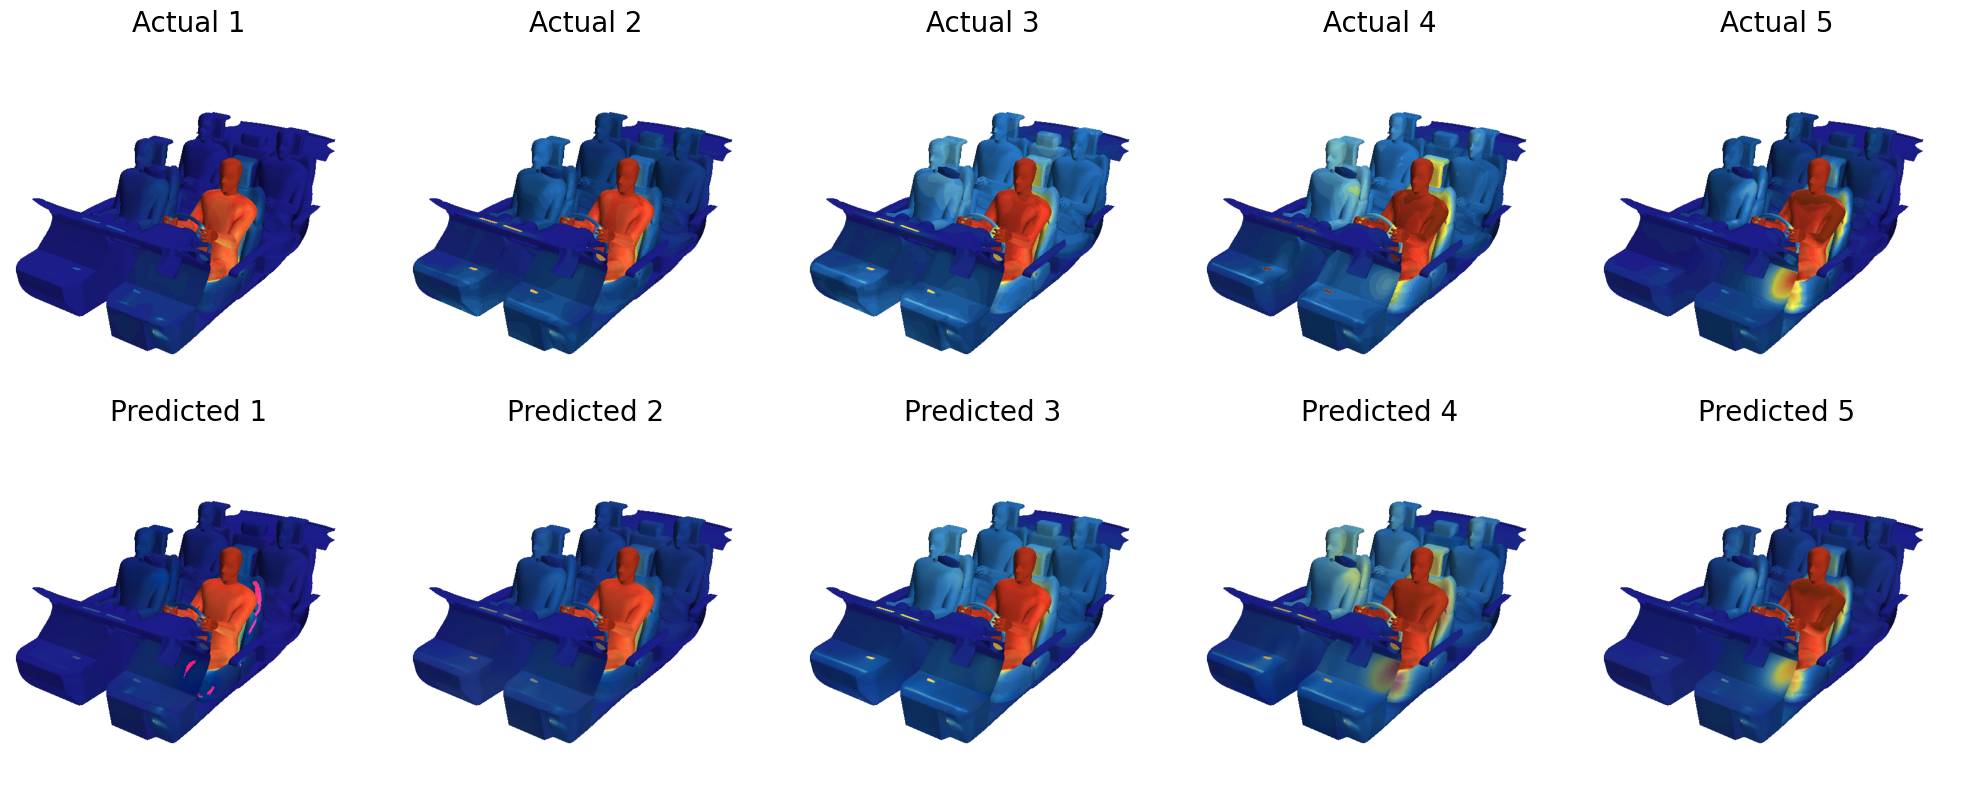

In [15]:
# Inference

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lists of actual and predicted image filenames
actual_images = [
    "33.png",
    "129.png",
    "385.png",
    "861.png",
    "1717.png"
]

predicted_images = [
    "predicted_image_1.png",
    "predicted_image_2.png",
    "predicted_image_3.png",
    "predicted_image_4.png",
    "predicted_image_5.png"
]

# Check if the length of both lists is the same
assert len(actual_images) == len(predicted_images), "The number of actual and predicted images must be the same."

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Plot actual images
for i, (ax, img) in enumerate(zip(axes[0], actual_images), start=1):
    ax.imshow(mpimg.imread(img))
    ax.set_title(f"Actual {i}", fontsize=20)
    ax.axis('off')

# Plot predicted images
for i, (ax, img) in enumerate(zip(axes[1], predicted_images), start=1):
    ax.imshow(mpimg.imread(img))
    ax.set_title(f"Predicted {i}", fontsize=20)
    ax.axis('off')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("combined_Actual_Predicted.png")
plt.show()